In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from altaipony.fakeflares import aflare

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import pytest

from funcs.model import daylength, on_off, lambert, great_circle_distance, dot_ensemble, model
from funcs.funcs import no_nan_inf
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Plots 

Text(0, 0.5, 'latitude [deg]')

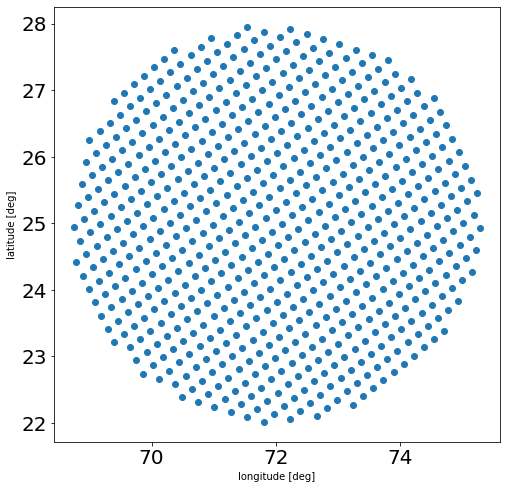

In [8]:
# plot a grid

#latitudes, longitudes = dot_ensemble(np.pi/2-np.pi/8,np.pi/2-np.pi/10,4,num_pts=1e6)
latitudes, longitudes = dot_ensemble(25/180*np.pi,np.pi/2-np.pi/10,3,num_pts=1e6)
plt.figure(figsize=(8,8))
plt.scatter(longitudes/np.pi*180, latitudes/np.pi*180)
#plt.scatter([180/2-180/10],[180/2-180/8],)
plt.xlabel("longitude [deg]")
plt.ylabel("latitude [deg]")
#plt.savefig(f"{CWD}/analysis/plots/model/dot_ensemble.png",dpi=300)

In [9]:
# Plot a model consisting of an ensemble of rotating flaring points on a sphere

I = 26.5 * np.pi / 180.
phi = np.linspace(0,6*np.pi,2000)
ampl = 20
fwhm = 3.
flare = aflare(phi, 3.1, fwhm, ampl,)

lamb, onoff, m = model(phi, latitudes, longitudes, flare, I)

Text(0.5, 1.0, 'Flare with rel. amplitude=20, and FWHM=3.0 rotation periods')

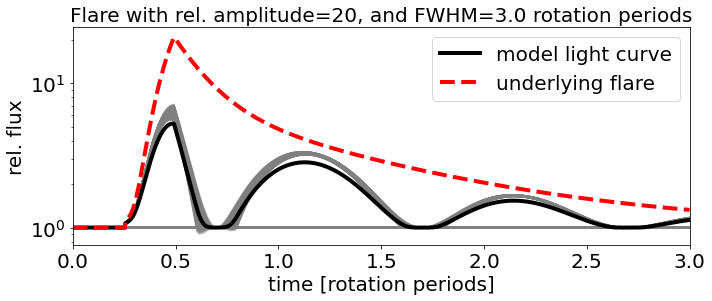

In [10]:
plt.figure(figsize=(10,4))
for l,oo in zip(lamb,onoff):
    plt.plot(phi/2/np.pi, l*oo*flare+1, alpha=.1, c="grey")
plt.plot(phi/2/np.pi,m+1,c="k",linewidth=4, label="model light curve")#,\naverage of individual\ngrid dots (in grey)")
plt.plot(phi/2/np.pi,flare+1, label="underlying flare",c="r",linestyle="dashed",linewidth=4)
plt.xlabel("time [rotation periods]",fontsize=20)
plt.ylabel("rel. flux",fontsize=20)
plt.xlim(0,3)
plt.legend(fontsize=20)
plt.yscale("log")
plt.tight_layout()
plt.title(f"Flare with rel. amplitude={ampl}, and FWHM={fwhm} rotation periods",fontsize=20)
#plt.savefig(f"{CWD}/analysis/plots/model/rotating_flaring_ensemble_lightcurve.png",dpi=300);


In [ ]:
# create a heatmap of an ensemble of rotating flaring points on a sphere (need the cell above)
from matplotlib.colors import LogNorm
plt.figure(figsize=(15,10))
plt.imshow((lamb*onoff*flare)[:,:], norm=LogNorm(),aspect="auto")
plt.colorbar(label="flux")
plt.xlabel("time",fontsize=15)
plt.ylabel("index of grid dot",fontsize=15)
plt.savefig(f"{CWD}/analysis/plots/model/rotating_flaring_ensemble_heatmap.png",dpi=300)

In [ ]:
# 10% percent area spot on the stellar surface
percent = 10
num_pts=1e4
indices = np.arange(0, num_pts, dtype=float) + 0.5

phi = np.arccos(1 - 2*indices/num_pts) #latitude
theta = np.pi * (1 + 5**0.5) * indices  #longitude

a = np.where(great_circle_distance(np.pi/3,- np.pi/4, np.pi/2 - phi%(2*np.pi), theta%(np.pi*2))<(percent/180*np.pi))[0]
phi2 = phi[a]
theta2 = theta[a]

x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
x2, y2, z2 = np.cos(theta2) * np.sin(phi2), np.sin(theta2) * np.sin(phi2), np.cos(phi2);
ax = plt.figure(figsize=(10,10)).add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=.1);
ax.scatter(x2, y2, z2, s=3.5, c="k");
plt.savefig(f"{CWD}/analysis/plots/model/10percent_spot_on_a_sphere.png",dpi=300)

In [ ]:
# plot a rotaionally modulated dot-flare
flare = aflare(phi, 1.5, 1.3, 1,)
plt.figure(figsize=(8,16))
l = 80/180*np.pi
I = np.arange(30,91,10)/180*np.pi
for i in I:
    D = daylength(l,i)
    modulation = lambert(phi,i,l)
    #plt.plot(phi/2/np.pi,modulation*on_off(D,phi),label=f"i={i/np.pi*180:.0f}" + r"$^{\circ}$")
    plt.plot(phi/2/np.pi,modulation*on_off(phi,D)*flare + i,label=f"i={i/np.pi*180:.0f}" + r"$^{\circ}$",
            linewidth=2,)
    plt.plot(phi/2/np.pi,flare + i,c="grey",linestyle="dotted")
plt.title(r"bright flaring dot at latitude 80$^{\circ}$ ",fontsize=15)
plt.xlabel("time [rotation periods]",fontsize=15)
plt.ylabel("flux",fontsize=15)
plt.legend(loc=(1.1,0),fontsize=15)
plt.xlim(0,3)
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/rotating_bright_dot_flare.png",dpi=300)

In [ ]:
# plot visibility as a function of day time
plt.figure(figsize=(12,4))
phi = np.linspace(0,6*np.pi,500) #(longitude)
daylengths = np.arange(.1,.91,.2)
for d in daylengths:
    plt.plot(phi/2/np.pi, on_off(phi,d), linewidth=d*2,c="k", label=f"day length / Prot={d:.1f}")
plt.legend(loc=(1.05,0))
plt.xlabel("time [days]")
plt.ylabel("visibility")
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/visibility_vs_day.png",dpi=300)

In [ ]:
# Plot daylengths:

I = np.linspace(0,np.pi/2,10)
L = np.linspace(-np.pi/2,np.pi/2, 500)[::-1]
plt.figure(figsize=(10,6))

    
for i in I:
    dl = []
    for l in L:
        dl.append(daylength(l,i))
    plt.plot(L/np.pi*180,dl,label=f"i={i/np.pi*180:.1f}")
plt.xlabel("latitude ",fontsize=15)
plt.ylabel("daylength",fontsize=15)
plt.ylim(-.1,1.1)
plt.xlim(-90,90)
plt.legend(loc=(1.1,0),fontsize=15)
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/daylength.png",dpi=300)